Link to original google colab : https://colab.research.google.com/drive/1cpP6an0MZ3szP1mPBoz_OApMMpTcKUsr?usp=sharing

## Import Libraries and Data

In [2]:
# Import all necessary library
#! pip install scikit-plot
import pandas as pd
import numpy as np

# word processing libraries
import nltk
import re, string
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, classify, NaiveBayesClassifier

# Model related libraries
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import lightgbm as lgb

# Others
import matplotlib.pyplot as plt
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wyatt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wyatt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wyatt\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
folder_path = "./"
train = pd.read_csv(folder_path+"df_tagged.csv",  encoding='utf-8-sig')
train.head()

,Unnamed: 0,review_id,review,rating,cluster_pred,category,catid
0,0,0,Ga disappointed neat products .. Meletot Hilsn...,1,109,Mixed,6
1,1,1,"Rdtanya replace broken glass, broken chargernya",1,228,Product-Quality,1
2,2,2,Nyesel bngt dsni shopping antecedent photo mes...,1,295,Mixed,6
3,3,3,Sent a light blue suit goods ga want a refund,1,29,Product-Spec,7
4,4,4,Pendants came with dents and scratches on its ...,1,96,Product-Spec,7


# EDA


In [ ]:
# Number of records before removing duplicate
train.shape

(209729, 3)

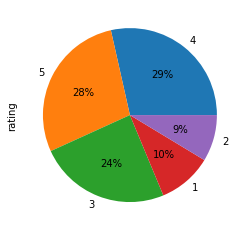

In [ ]:
# Visualise distribution of star rating

train["rating"].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
# Create a function to get the word count for each review
def get_word_count(x):
    return len(x.split())

In [ ]:
# Retrieve length and word count for each review
train['review_length']=train['review'].apply(len)
train['word_count']=train['review'].apply(get_word_count)

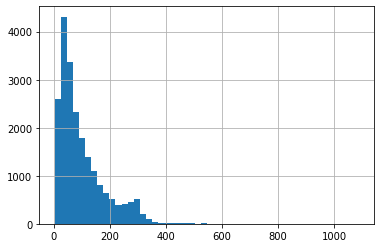

In [ ]:
# Length of review for 1 star rating
train[train["rating"]==1].review_length.hist(bins=50)

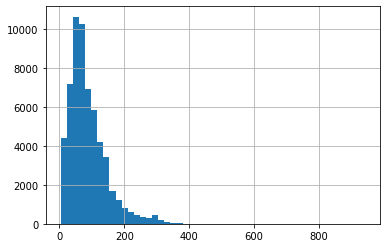

In [ ]:
# Length of review for 5 star rating
train[train["rating"]==5].review_length.hist(bins=50)

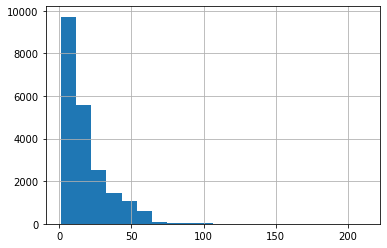

In [ ]:
# word count of review for 1 star rating
train[train["rating"]==1].word_count.hist(bins=20)

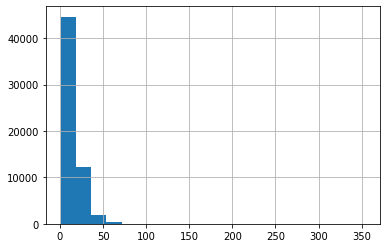

In [ ]:
# word count of review for 5 star rating
train[train["rating"]==5].word_count.hist(bins=20)

# Data Preprocessing

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
# Create Function for removing stop words and lemmatize it
nltk.download('stopwords')
stop_list = stopwords.words("english")
stop_list += string.punctuation
def remove_noise(review_tokens, stop_words):
    cleaned_tokens = []
    for token, tag in pos_tag(review_tokens):
        token = re.sub(r'\u200b', "", token)
        token = remove_emoji(token)
        """
        if "n't" in token:
            token = 'not'
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
            """
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token)

        if (len(token) > 2 and len(token) < 16 and token.lower() not in stop_list):
            cleaned_tokens.append(token.lower())
    cleaned_tokens = set(cleaned_tokens)
    return cleaned_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Train Valisation Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train["review"], train["rating"], test_size=0.2, random_state=42)
# Train Validation split
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Tokenise review for train and test 
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
review_token_train = [tokenizer.tokenize(review) for review in X_train]
review_token_test = [tokenizer.tokenize(review) for review in X_test]

In [ ]:
# Remove noise for train and test 
clean_token_train = [remove_noise(review, stop_list) for review in review_token_train]
clean_token_test = [remove_noise(review, stop_list) for review in review_token_test]

In [ ]:
# Combine clean token into string
from nltk.tokenize.treebank import TreebankWordDetokenizer
clean_text_train = [TreebankWordDetokenizer().detokenize(tokens) for tokens in clean_token_train]
clean_text_test = [TreebankWordDetokenizer().detokenize(tokens) for tokens in clean_token_test]

# Word to Vector Pre-processing


## Tf-idf Word Vectoriser


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_v = TfidfVectorizer(min_df = 0.001, max_df =0.5,ngram_range= (1,5), max_features=3000)#TfidfVectorizer(min_df = 0.0001, max_df =0.9, max_features=2000) 
x_train_tfidf = tfidf_v.fit_transform(clean_text_train)
x_test_tfidf = tfidf_v.transform(clean_text_test)

### Pickle

In [ ]:
# clean_text_train, clean_text_test, x_train_tfidf,x_test_tfidf, y_train, y_test
"""
import pickle
pkl_filename = folder_path + "pickle_data/y_train.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(y_train, file)

pkl_filename = folder_path + "pickle_data/y_test.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(y_test, file)

pkl_filename = folder_path + "pickle_data/clean_text_train.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clean_text_train, file)

pkl_filename = folder_path + "pickle_data/clean_text_test.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clean_text_test, file)

pkl_filename = folder_path + "pickle_data/x_train_tfidf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(x_train_tfidf, file)

pkl_filename = folder_path + "pickle_data/x_test_tfidf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(x_test_tfidf, file)
"""

'\nimport pickle\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/y_train.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(y_train, file)\n\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/y_test.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(y_test, file)\n\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/clean_text_train.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(clean_text_train, file)\n\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/clean_text_test.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(clean_text_test, file)\n\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/x_train_tfidf.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(x_train_tfidf, file)\n\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/x_test_tfidf.pkl"\nwith open(pkl_filename, \'wb\') as file:\n    pickle.dump(x_test_tfidf, file)\n'

## Word2Vec

In [ ]:
# Word2vec
import gensim
# Parameters for Word2Vec Model
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
# Split each word and store it in a list
doc = [txt.split() for txt in clean_text_train]

In [ ]:
# Build vocab for Word2Vec Model
w2v_model.build_vocab(doc)

In [ ]:
# Check Size of Vocab
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab Size:", vocab_size)

Vocab Size: 6801


In [ ]:
# Train Word2Vec Model
w2v_model.train(doc, total_examples=len(doc), epochs=W2V_EPOCH)

(30508748, 44103776)

In [ ]:
w2v_model.wv.init_sims()


In [ ]:
import logging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.vectors_norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        # logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])


def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [ ]:
train_tokenized = [w2v_tokenize_text(x) for x in X_train]
test_tokenized = [txt.split() for txt in clean_text_test]

print(train_tokenized[:10])
print(test_tokenized[:10])

X_train_word_average = word_averaging_list(w2v_model,train_tokenized)
X_test_word_average = word_averaging_list(w2v_model,test_tokenized)

[['aq', 'not', 'repeat', 'order', 'nkakadismaya', 'bute', 'would', 'qng', 'less', 'un', 'bnbayaran', 'we', 'doing', 'wrong', 'color', 'Sending', 'you', 'more', 'and', 'another', 'un', 'another', 'seller', 'will', 'inform', 'the', 'avail', 'colors', 'but', 'you', 'just', 'mkabenta', 'kahit', 'iun', 'order', 'pnadadala', 'you'], ['Excellent', 'product', 'quality', 'Doing', 'very', 'reputable', 'shop', 'Serve', 'very', 'enthusiastic', 'All', 'dishes', 'were', 'very', 'LOG', 'f.', 'Long-term', 'cough', 'ug', 'Se', 'ạk', 'shop'], ['Not', 'similar'], ['Barang.nya', 'bgus', 'trimahkasih', 'boss', 'fitting', 'number', 'to', 'order'], ['baguuuuuuuuuuuuussssssssssssssssssssssssssssssss', 'bangeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeetttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt', 'makasiiiiihhhhhh', 'kaka.cus', 'yaaa', 'sukaaaaaa', 'sekali🙏😘😘😘😘😘😘😘😘😘😘😘😘😘😘😍😍😍😍😍😍😍😍😍😍😍😍'], ['Very', 'accommodating', 'seller'], ['Well-packaged', 'Item', 'shipped', 'immediately', 'Will', 'or

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v_model)
mean_embedded = mean_embedding_vectorizer.fit_transform(clean_text_train)
mean_embedded_test = mean_embedding_vectorizer.transform(clean_text_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


# Model Training

## K-Fold Validation Function

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import log_loss, plot_confusion_matrix
!pip install scikit-plot
import scikitplot.plotters as skplt

def evaluate_features(X, y, clf=None):
    if clf is None:
        clf = LogisticRegression()
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold( random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

## Naive Bayes

### Tf-idf Vectoriser

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.2336212805618356
Accuracy: 0.43792018309254754
alpha:  0.001
Train accuracy:  0.4562559973298844
Test accuracy:  0.44295046011538647



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Log loss: 1.225038351491995
Accuracy: 0.4377771420397654
alpha:  0.01
Train accuracy:  0.45624407717110793
Test accuracy:  0.4430219806417775



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instea

Log loss: 1.2175134330951538
Accuracy: 0.4378248223906928
alpha:  0.1
Train accuracy:  0.4562738775680492
Test accuracy:  0.4431173413436323



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Log loss: 1.2093033513617797
Accuracy: 0.43944595432222383
alpha:  1
Train accuracy:  0.4564586400290852
Test accuracy:  0.4432842225718781



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instea

Log loss: 1.2377797201856289
Accuracy: 0.4286463548371716
alpha:  10
Train accuracy:  0.45793673971737303
Test accuracy:  0.4443331902922806



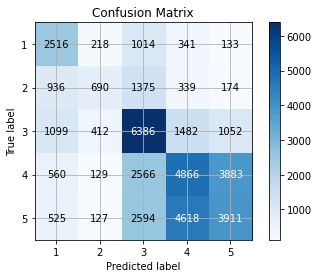

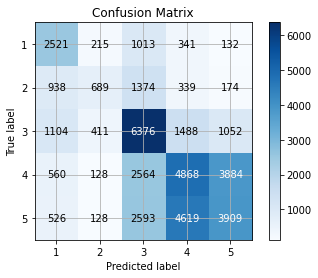

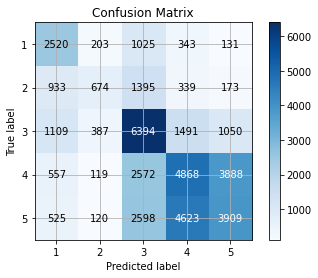

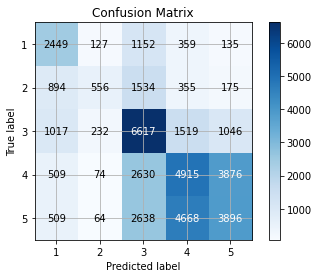

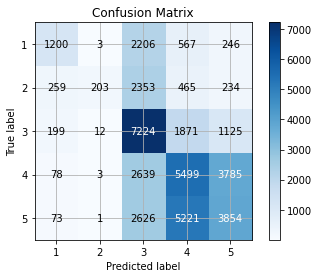

In [ ]:
from sklearn import naive_bayes
alpha_list = [0.001,0.01,0.1,1,10]
for i in alpha_list:
  mnb_tfidf = naive_bayes.MultinomialNB(alpha = i)
  mnb_tfidf.fit(x_train_tfidf,y_train)
  evaluate_features(x_test_tfidf,y_test, mnb_tfidf)
  print("alpha: ", str(i))
  print("Train accuracy: ", str(mnb_tfidf.score(x_train_tfidf,y_train)))
  print("Test accuracy: ", str(mnb_tfidf.score(x_test_tfidf,y_test)))
  print("")

In [ ]:
mnb_tfidf = naive_bayes.MultinomialNB(alpha = 0.1)
mnb_tfidf.fit(x_train_tfidf,y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [ ]:
# get most important feature for each class
rating_list = [1,2,3,4,5]
review_feat = {}
feature_list =tfidf_v.get_feature_names()
log_likelihood = mnb_tfidf.feature_log_prob_
for i in range(len(rating_list)):
    max_list = np.max(log_likelihood[np.arange(len(log_likelihood))!=i], axis = 0)
    diff = log_likelihood[i]-max_list
    top10 = diff.argsort()[-10:][::-1]
    review_feat[rating_list[i]] =[]
    for feat in top10:
        review_feat[rating_list[i]].append(feature_list[feat])
pd.DataFrame(review_feat)

,1,2,3,4,5
0,product poor,product quality standard,price speed well response,good real,beautiful packaging
1,terrible,quality standard,well response seller quality,sellernya,seller friendly fast
2,waste,quality standard price,well response seller quality delivery,sampai,thank fast
3,defective,product quality standard price,product price speed well response,packaging service,fast satisfied
4,quality poor,standard price,speed well response seller quality,sir,certainly beautiful
5,told,product standard,price speed well response seller,fast cheap,principal
6,received wrong,temporary,price speed well,quality super good,also like
7,severe,standard,product price speed well,ship service speed awesome fabulous,product certainly beautiful packaging
8,receive,fair,speed well response seller,service speed awesome fabulous,certainly beautiful packaging
9,business,standard speed,speed well quality delivery,haha,product certainly beautiful


### Word2Vec

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(mean_embedded)
X_train_norm = scaler.transform(mean_embedded)
X_test_norm = scaler.transform(mean_embedded_test)

alpha_list = [0.001,0.01,0.1,1,10]
for i in alpha_list:
  mnb_w2v = MultinomialNB(alpha=i)
  mnb_w2v.fit(X_train_norm, y_train)

  print("alpha: ", str(i))
  print("====================================")
  print("Word2Vec w Tf-idf")
  print("Train accuracy: ", str(mnb_w2v.score(X_train_norm,y_train)))
  print("Test accuracy: ", str(mnb_w2v.score(X_test_norm,y_test)))
  print("=====================================")


alpha:  0.001
Word2Vec w Tf-idf
Train accuracy:  0.3305877234284761
Test accuracy:  0.32913746245172365
alpha:  0.01
Word2Vec w Tf-idf
Train accuracy:  0.3305877234284761
Test accuracy:  0.32913746245172365
alpha:  0.1
Word2Vec w Tf-idf
Train accuracy:  0.3305877234284761
Test accuracy:  0.32913746245172365
alpha:  1
Word2Vec w Tf-idf
Train accuracy:  0.3305877234284761
Test accuracy:  0.32913746245172365
alpha:  10
Word2Vec w Tf-idf
Train accuracy:  0.3305579230315348
Test accuracy:  0.32916130262718735


In [ ]:
mnb_w2v = MultinomialNB(alpha=0.1)
mnb_w2v.fit(X_train_norm, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

## Logistics Regression

### Tf-idf Vectoriser

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.371687657893207
Accuracy: 0.3911695990082487
C:  0.01
Train accuracy:  0.45555270796207004
Test accuracy:  0.44020883993706195



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.209469671908938
Accuracy: 0.44738473275163304
C:  0.1
Train accuracy:  0.48220618298635737
Test accuracy:  0.4635006913650884



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.1599053164464126
Accuracy: 0.4543699041624946
C:  1
Train accuracy:  0.4876656157060012
Test accuracy:  0.4649311018929099



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.1854116275443454
Accuracy: 0.44924426643780097
C:  10
Train accuracy:  0.4889708730920296
Test accuracy:  0.4648119010155915



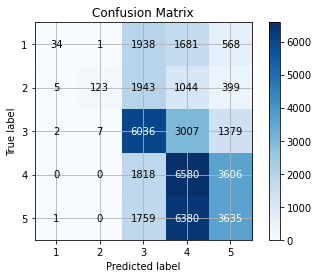

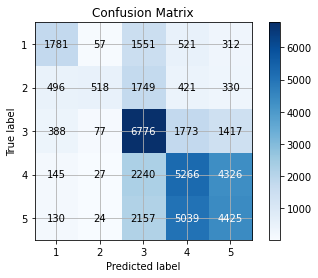

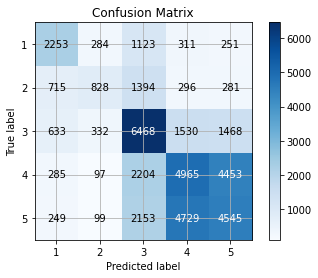

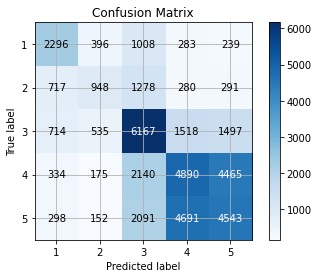

In [ ]:
from sklearn.linear_model import LogisticRegression
c_list = [0.01,0.1,1,10]
for i in c_list:
  lr_tfidf = LogisticRegression(C = i , solver= "newton-cg", multi_class = "multinomial")
  lr_tfidf.fit(x_train_tfidf,y_train)
  evaluate_features(x_test_tfidf,y_test, lr_tfidf)
  print("C: ", str(i))
  print("Train accuracy: ", str(lr_tfidf.score(x_train_tfidf,y_train)))
  print("Test accuracy: ", str(lr_tfidf.score(x_test_tfidf,y_test)))
  print("")

In [ ]:
lr_tfidf = LogisticRegression(C = 1)
lr_tfidf.fit(x_train_tfidf,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
feature_list =tfidf_v.get_feature_names()
mlr_coef = lr_tfidf.coef_
rating_list = [1,2,3,4,5]
review_feat = {}

for i in range(len(rating_list)):
    max_list = np.max(mlr_coef[np.arange(len(mlr_coef))!=i], axis = 0)
    diff = mlr_coef[i]-max_list
    top10 = diff.argsort()[-10:][::-1]
    review_feat[rating_list[i]] =[]
    for feat in top10:
        review_feat[rating_list[i]].append(feature_list[feat])
pd.DataFrame(review_feat)

,1,2,3,4,5
0,terrible,standard,shop provided,beautiful certainly,extremely
1,poor,fair,quality product,dsni,order immediately
2,severe,standard speed,value quality,early,fast satisfied
3,bad,general,product value quality,sellernya,quality satisfied
4,fake,quality,product quality price good,haha,principal
5,waste,standard response,quality price good,day next,mother
6,selling,product quality,good merchandise,packaging service,beautiful packaging
7,told,ordinary,price speed well,good real,product excellent quality
8,low,price standard speed,service carrier,color nice,super good
9,disappointing,temporary,good seller,original speed excellent,commodity


### Word2Vec

C:  0.01


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.182226399483499
Accuracy: 0.4532970962666285
Train accuracy:  0.4628478451332972
Test accuracy:  0.45763600820102035
C:  0.1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.182226399483499
Accuracy: 0.4532970962666285
Train accuracy:  0.465112675300835
Test accuracy:  0.45837505364039477
C:  1


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.182226399483499
Accuracy: 0.4532970962666285
Train accuracy:  0.46629873109909825
Test accuracy:  0.45796977065751204
C:  10


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.182226399483499
Accuracy: 0.4532970962666285
Train accuracy:  0.4663464117342043
Test accuracy:  0.45861345539503173


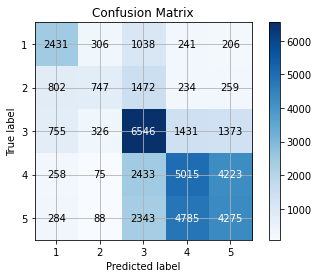

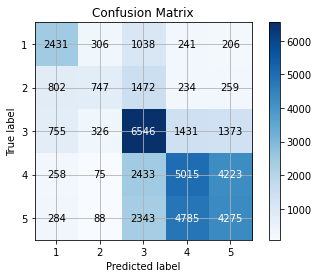

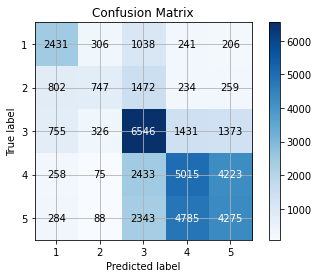

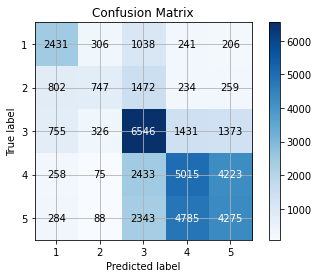

In [ ]:
c_list = [0.01,0.1,1,10]
for i in c_list:
  lr_w2v = LogisticRegression(C = i , solver= "newton-cg", multi_class = "multinomial")
  lr_w2v.fit(mean_embedded, y_train)
  print("C: ", str(i))
  print("====================================")
  evaluate_features(mean_embedded_test,y_test, lr_tfidf)
  print("Train accuracy: ", str(lr_w2v.score(mean_embedded,y_train)))
  print("Test accuracy: ", str(lr_w2v.score(mean_embedded_test,y_test)))
  print("=====================================")

In [ ]:
x_train_tfidf.shape

(167783, 1591)

In [ ]:
lr_w2v = LogisticRegression(C = 0.1 , solver= "newton-cg", multi_class = "multinomial")
lr_w2v.fit(mean_embedded, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

## SGD


### Tf-idf


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_tfidf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
sgd_tfidf.fit(x_train_tfidf,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Word2Vec

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_w2v = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
sgd_w2v.fit(mean_embedded,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## SVM

###Tf-idf Vectoriser

In [ ]:
svm = SVC(kernel='linear')

svm.fit(x_train_tfidf, y_train)

## LGBM

### Tf-idf Vectoriser

In [ ]:
# train validation split to make sure LGBM dont see test data during validation
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(x_train_tfidf, y_train, test_size=0.2, random_state=42)

In [ ]:
# training of model take time, you may load our model instead
train_data = lgb.Dataset(X_train_lgb, y_train_lgb)
test_data = lgb.Dataset(X_val_lgb,y_val_lgb)
parameters = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'num_class' : 6,
}

lgb_tfidf = lgb.train(parameters,train_data,valid_sets=test_data,num_boost_round=5000,early_stopping_rounds=100)

[1]	valid_0's multi_logloss: 1.48908
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.47529
[3]	valid_0's multi_logloss: 1.46256
[4]	valid_0's multi_logloss: 1.45123
[5]	valid_0's multi_logloss: 1.44041
[6]	valid_0's multi_logloss: 1.43028
[7]	valid_0's multi_logloss: 1.42071
[8]	valid_0's multi_logloss: 1.41197
[9]	valid_0's multi_logloss: 1.40324
[10]	valid_0's multi_logloss: 1.395
[11]	valid_0's multi_logloss: 1.3873
[12]	valid_0's multi_logloss: 1.38006
[13]	valid_0's multi_logloss: 1.37364
[14]	valid_0's multi_logloss: 1.36717
[15]	valid_0's multi_logloss: 1.36109
[16]	valid_0's multi_logloss: 1.35535
[17]	valid_0's multi_logloss: 1.34966
[18]	valid_0's multi_logloss: 1.34459
[19]	valid_0's multi_logloss: 1.33935
[20]	valid_0's multi_logloss: 1.33455
[21]	valid_0's multi_logloss: 1.32983
[22]	valid_0's multi_logloss: 1.32518
[23]	valid_0's multi_logloss: 1.32095
[24]	valid_0's multi_logloss: 1.3168
[25]	valid_0's multi_logloss: 1.31273


In [ ]:
# save model as pickle file 
"""
import pickle
pkl_filename = folder_path + "models/lgbm_tfidf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lgb_tfidf, file)
    """

In [ ]:
# Load model from file
pkl_filename = folder_path + "models/lgbm_tfidf.pkl"
with open(pkl_filename, 'rb') as file:
    lgb_tfidf_load = pickle.load(file)


In [ ]:
# Top 10 most important feature for LGBM
feature_list =tfidf_v.get_feature_names()
lgbm_feat_list = lgb_tfidf_load.feature_importance().argsort()[-10:][::-1]
for i in lgbm_feat_list:
  print(feature_list[i])

kaka
done
product use
response seller quality
good seller
product response
severe
took
price original speed response
time quality delivery


In [ ]:
# current model
from sklearn.metrics import precision_score, accuracy_score
y_pred = lgb_tfidf.predict(x_test_tfidf)
y_pred = [np.argmax(line) for line in y_pred]

accuracy_score(y_pred,y_test)

0.5000953607018548

### Word2Vec

In [ ]:
X_train_me, X_val_me, y_train_me, y_val_me = train_test_split(mean_embedded, y_train, test_size=0.2, random_state=42)

In [ ]:
train_data = lgb.Dataset(X_train_me , y_train_me)
test_data = lgb.Dataset(X_val_me ,y_val_me)
lgb_w2v = lgb.train(parameters,train_data,valid_sets=test_data,num_boost_round=5000,early_stopping_rounds=100)

[1]	valid_0's multi_logloss: 1.48611
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.47001
[3]	valid_0's multi_logloss: 1.4549
[4]	valid_0's multi_logloss: 1.44112
[5]	valid_0's multi_logloss: 1.42798
[6]	valid_0's multi_logloss: 1.41607
[7]	valid_0's multi_logloss: 1.40481
[8]	valid_0's multi_logloss: 1.3941
[9]	valid_0's multi_logloss: 1.38415
[10]	valid_0's multi_logloss: 1.37473
[11]	valid_0's multi_logloss: 1.36574
[12]	valid_0's multi_logloss: 1.35738
[13]	valid_0's multi_logloss: 1.34947
[14]	valid_0's multi_logloss: 1.34192
[15]	valid_0's multi_logloss: 1.3347
[16]	valid_0's multi_logloss: 1.32777
[17]	valid_0's multi_logloss: 1.32116
[18]	valid_0's multi_logloss: 1.31477
[19]	valid_0's multi_logloss: 1.30879
[20]	valid_0's multi_logloss: 1.30292
[21]	valid_0's multi_logloss: 1.29736
[22]	valid_0's multi_logloss: 1.29201
[23]	valid_0's multi_logloss: 1.28688
[24]	valid_0's multi_logloss: 1.28189
[25]	valid_0's multi_logloss: 1.27727

In [ ]:
# Save model as pickle file
"""
import pickle
pkl_filename = folder_path + "models/lgbm_w2v.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lgb_w2v, file)
    """

In [ ]:
# Load model from file
pkl_filename = folder_path + "models/lgbm_w2v.pkl"
with open(pkl_filename, 'rb') as file:
    lgb_w2v_load = pickle.load(file)


In [ ]:
# Top 10 most important feature for LGBM 
# But it is not interpretable
feature_list =lgb_w2v_load.feature_name()
lgbm_feat_list = lgb_w2v_load.feature_importance().argsort()[-10:][::-1]
for i in lgbm_feat_list:
  print(feature_list[i])

Column_257
Column_261
Column_251
Column_24
Column_292
Column_88
Column_198
Column_296
Column_279
Column_63


In [ ]:
# Test accuracy score
from sklearn.metrics import precision_score, accuracy_score
y_pred = lgb_w2v.predict(mean_embedded_test)
y_pred = [np.argmax(line) for line in y_pred]

accuracy_score(y_pred,y_test)

0.5705192390215992

## Random Forest 

### Tf-idf Vectoriser

In [ ]:
rfc = RandomForestClassifier(random_state=2020)
rfc.fit(x_train_tfidf, y_train)

## Extra Tree

###Tf-idf

In [ ]:
etc = ExtraTreesClassifier(n_estimators=300, random_state=2020)
etc.fit(x_train_tfidf, y_train)

## Deep Learning

## LSTM

In [ ]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_text_train)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(clean_text_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(clean_text_test), maxlen=SEQUENCE_LENGTH)

In [ ]:
labels = train['rating'].unique().tolist()
labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("Log Loss:",score[0])
print("Accuracy:",score[1])


# Evaluation

## General Function

## Basic Score

In [ ]:
# Create function for to evaluate basic scores
def score_calculation(y_true,y_pred):
  print("Weighted Precision: ", str(precision_score(y_true,y_pred, average = "weighted")))
  print("Weighted Recall: ", str(recall_score(y_true,y_pred, average = "weighted")))
  print("Weighted F1 Score: ", str(f1_score(y_true,y_pred, average = "weighted")))
  print("Accuracy Score: ", str(accuracy_score(y_true,y_pred)))
  print("Confusion Matrix: ")
  print(confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5]))
  skplt.plot_confusion_matrix(y_true, y_pred)


Naive Bayes Tf-idf

Weighted Precision:  0.43765661214336926
Weighted Recall:  0.44051876221808994
Weighted F1 Score:  0.4302266553366421
Accuracy Score:  0.44051876221808994
Confusion Matrix: 
[[2666  161  939  324  132]
 [1019  671 1316  308  200]
 [1169  430 6264 1529 1039]
 [ 584  131 2457 4483 4349]
 [ 610  126 2423 4222 4394]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


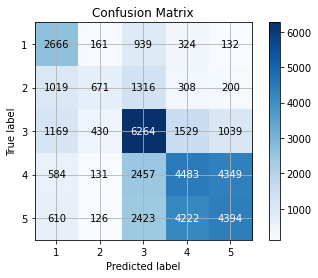

In [ ]:
y_pred = mnb_tfidf.predict(x_test_tfidf)
score_calculation(y_test,y_pred)

Naive Bayes Word2Vec


Weighted Precision:  0.35909499929151295
Weighted Recall:  0.36444476231345063
Weighted F1 Score:  0.34918556958160446
Accuracy Score:  0.36444476231345063
Confusion Matrix: 
[[1969   17 1146  663  427]
 [ 848   25 1451  571  619]
 [1098   26 3710 2329 3268]
 [ 468    6 1841 4945 4744]
 [ 467   11 1861 4798 4638]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


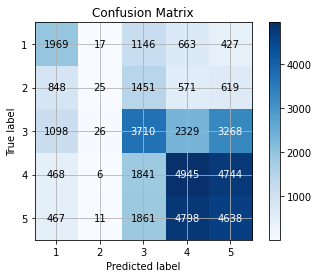

In [ ]:
y_pred = mnb_w2v.predict(X_test_norm)
score_calculation(y_test,y_pred)

Logistics Regression Tf-idf

Weighted Precision:  0.4650596152022876
Weighted Recall:  0.4652648643494016
Weighted F1 Score:  0.4579858989995616
Accuracy Score:  0.4652648643494016
Confusion Matrix: 
[[2481  215 1088  269  169]
 [ 775  848 1371  290  230]
 [ 717  327 6571 1526 1290]
 [ 302   93 2130 5038 4441]
 [ 283   81 2096 4737 4578]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


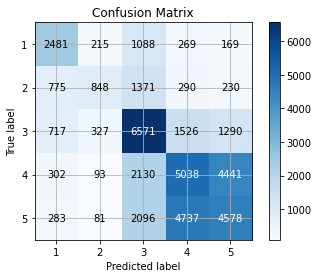

In [ ]:
y_pred = lr_tfidf.predict(x_test_tfidf)
score_calculation(y_test,y_pred)

Logistics Regression Word2Vec

Weighted Precision:  0.4563260576184941
Weighted Recall:  0.45796977065751204
Weighted F1 Score:  0.4483210501995711
Accuracy Score:  0.45796977065751204
Confusion Matrix: 
[[2528  264 1030  265  135]
 [ 860  757 1452  261  184]
 [ 759  306 6668 1479 1219]
 [ 261   71 2424 4303 4945]
 [ 292   68 2370 4091 4954]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


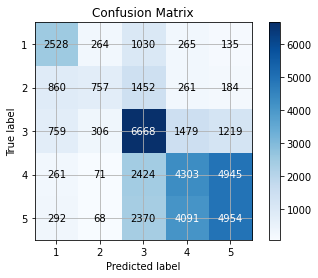

In [ ]:
y_pred = lr_w2v.predict(mean_embedded_test)
score_calculation(y_test,y_pred)

SVM Tf-idf

In [ ]:
y_pred = svm.predict(x_test_tfidf)
score_calculation(y_test,y_pred)

SGD Tf-idf

Weighted Precision:  0.4385497981043428
Weighted Recall:  0.44213989414962096
Weighted F1 Score:  0.4329311213264918
Accuracy Score:  0.44213989414962096
Confusion Matrix: 
[[2806  172  737  192  315]
 [1084  795 1068  224  343]
 [1191  419 6040 1232 1549]
 [ 615  231 2227 3974 4957]
 [ 628  213 2197 3806 4931]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


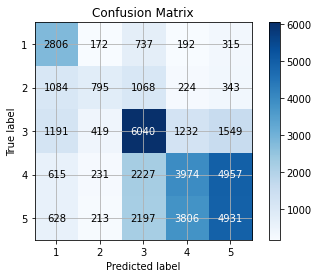

In [ ]:
y_pred = sgd_tfidf.predict(x_test_tfidf)
score_calculation(y_test,y_pred)

SGD Word2Vec

Weighted Precision:  0.43457359980672905
Weighted Recall:  0.4344395174748486
Weighted F1 Score:  0.4186611079974316
Accuracy Score:  0.4344395174748486
Confusion Matrix: 
[[2707  134 1114  168   99]
 [1018  653 1417  279  147]
 [1088  284 6642 1666  751]
 [ 610  163 2909 4928 3394]
 [ 627  115 2794 4946 3293]]


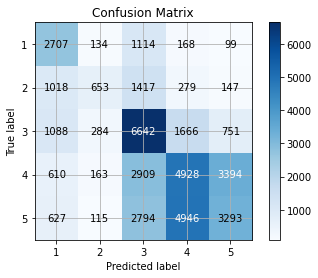

In [ ]:
y_pred = sgd_w2v.predict(mean_embedded_test)
score_calculation(y_test,y_pred)

Light GBM Tf-idf

In [ ]:
"""
import pickle
pkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/x_train_tfidf.pkl"
with open(pkl_filename, 'rb') as file:
  x_test_tfidf = pickle.load(file)
  """

'\nimport pickle\npkl_filename = "/content/drive/My Drive/ML_Project/pickle_data/x_train_tfidf.pkl"\nwith open(pkl_filename, \'rb\') as file:\n  x_test_tfidf = pickle.load(file)\n  '

Weighted Precision:  0.4996992835482453
Weighted Recall:  0.5000953607018548
Weighted F1 Score:  0.49815249678348394
Accuracy Score:  0.5000953607018548
Confusion Matrix: 
[[2494  376  787  358  207]
 [ 634 1201 1053  358  268]
 [ 580  479 6301 1678 1393]
 [ 231  145 1640 5376 4612]
 [ 235  131 1563 4241 5605]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


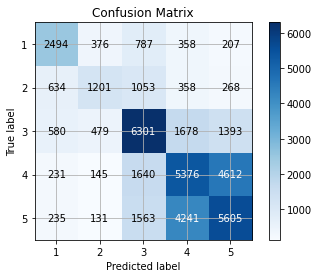

In [ ]:
y_pred = lgb_tfidf.predict(x_test_tfidf)
y_pred = [np.argmax(line) for line in y_pred]
score_calculation(y_test,y_pred)

Light GBM Word2Vec

Weighted Precision:  0.574282032230161
Weighted Recall:  0.5705192390215992
Weighted F1 Score:  0.5679870198528858
Accuracy Score:  0.5705192390215992
Confusion Matrix: 
[[2864  204  816  193  145]
 [ 556 1477 1089  208  184]
 [ 487  238 7318 1146 1242]
 [ 175   62 1463 5931 4373]
 [ 166   63 1385 3820 6341]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


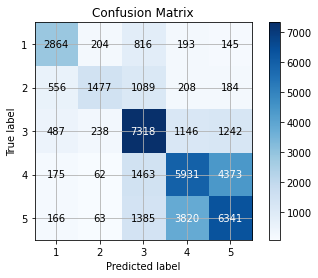

In [ ]:

y_pred = lgb_w2v.predict(mean_embedded_test)
y_pred = [np.argmax(line) for line in y_pred]
score_calculation(y_test,y_pred)


Random Forest Classifier Tf-idf

In [ ]:
y_pred = rfc.predict(x_test_tfidf)
score_calculation(y_test,y_pred)

Extra Tree Classifier Tf-idf

In [ ]:
y_pred = etc.predict(x_test_tfidf)
score_calculation(y_test,y_pred)